# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import progressbar
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

%matplotlib inline

# read in the json files
portfolio = pd.read_json('workspace/data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('workspace/data/profile.json', orient='records', lines=True)
transcript = pd.read_json('workspace/data/transcript.json', orient='records', lines=True)

# Data Exploration
### 1. Export portfolio dataset

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
# number of rows and columns
portfolio.shape

(10, 6)

In [4]:
# columns name and data type and null value
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
# number of unique ids
portfolio['id'].nunique()

10

In [6]:
# number of unique offer_type
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [7]:
# full dataset order by offer_type and difficulty
portfolio.sort_values(by=['offer_type','difficulty'])

,reward,channels,difficulty,duration,offer_type,id
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


### Summary
1. There are 10 rows and 6 columns in portfolio dataset
2. No null values in the dataset
3. There are 10 kinds of portfolio without depulicates
4. There are 3 types of offer: 'bogo', 'informational', 'discount'

### 2. Export profile dataset

In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
# number of rows and columns
profile.shape

(17000, 5)

In [10]:
# columns name and data type and null value
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
# number of null values for each columns
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [12]:
# of null values by ages
profile.groupby(['age'])['gender','income'].agg(lambda x: x.isnull().sum()).sort_values(by=['income'],ascending=False).head()

<ipython-input-12-433ce22f9d86>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  profile.groupby(['age'])['gender','income'].agg(lambda x: x.isnull().sum()).sort_values(by=['income'],ascending=False).head()


,gender,income
age,,
118,2175,2175.0
72,0,0.0
80,0,0.0
79,0,0.0
78,0,0.0


In [13]:
# number of unique ids
profile['id'].nunique()

17000

In [14]:
# unique value in gender column
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [15]:
# number of records by gender
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [16]:
# income column statistics 
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

<AxesSubplot:>

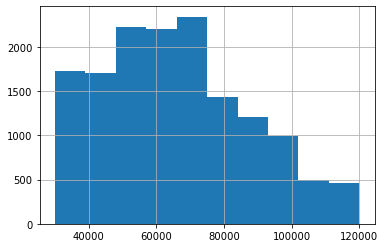

In [17]:
# histogram chart of income
profile['income'].hist()

### Summary
1. There are 17000 rows and 5 columns in the profile dataset
2. There are 2175 null vlaues in gender and income columns
3. Dig more we can find the null values came from rows with 'age'=118, think we can drop those values
4. No deplicated id in dataset
5. There are three kinds of gender:'F', 'M', 'O'
6. The income range from 30000 to 120000, average is 65405

### 3. Export transcript dataset

In [18]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [19]:
# number of rows and columns
transcript.shape

(306534, 4)

In [20]:
# columns name and data type and null value
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
# create a copy from transcript data set
transcript_duplicate_count=transcript.copy()

# change the value column data type from direct to string
transcript_duplicate_count['value']=transcript_duplicate_count.value.astype(str)

# count duplicate rows
transcript_duplicate_count.duplicated().sum()

397

In [22]:
# number of records by event
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [23]:
# transation event data frame
transcript[transcript['event'] == 'transaction'].head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


### Summary
1. There are 306534 rows and 4 columns in the transcript dataset
2. There are no null values in dataset, but 397 duplicated rows
3. There are four types of event: transaction, offer received, offer viewed, offer completed
4. The value column is different from transaction event and other offer events, value in transaction are amount of transaction, while value in offer events are offer_id

# Data Preprocessing
### 1. Clean Portfolio Dataset

In [24]:
# create new portfolio data set copy from portfolio
portfolio_new=portfolio.copy()

In [25]:
portfolio_new.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [26]:
# rename id column to offer_id
portfolio_new.rename(columns={'id':'offer_id'},inplace=True)

In [27]:
# change duration column from days to hours because the time in transaction is hours
portfolio_new['duration'] = portfolio_new['duration']*24

# rename duration column to duration_hours
portfolio_new.rename(columns={'duration':'duration_hours'},inplace=True)

In [28]:
# get unique channels
channels=[]
for i in range(portfolio_new.shape[0]):
    channels.extend(portfolio_new.channels[i])
channels=set(channels)

In [29]:
channels

{'email', 'mobile', 'social', 'web'}

In [30]:
# create each channel as column and assign value
for i in channels:
    portfolio_new[i]=portfolio_new['channels'].apply(lambda x: 1 if i in x else 0)

In [31]:
# drop original channels column
portfolio_new.drop('channels', axis=1, inplace=True)

In [32]:
# get dummies for offer_type
offer_type=pd.get_dummies(portfolio_new['offer_type'])

In [33]:
# merge offer_type in portfolio_new dataframe
portfolio_new=pd.concat([portfolio_new, offer_type], axis=1, sort=False)

In [34]:
# drop off_type column
portfolio_new.drop('offer_type', axis=1, inplace=True)

In [35]:
# replace the offer_id by num ids
labels_offer_id = portfolio_new['offer_id'].astype('category').cat.categories.tolist()
offer_id_num_map = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
portfolio_new.replace(offer_id_num_map, inplace=True)

In [36]:
offer_id_num_map

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
  '2298d6c36e964ae4a3e7e9706d1fb8c2': 2,
  '2906b810c7d4411798c6938adc9daaa5': 3,
  '3f207df678b143eea3cee63160fa8bed': 4,
  '4d5c57ea9a6940dd891ad53e9dbe8da0': 5,
  '5a8bc65990b245e5a138643cd4eb9837': 6,
  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7,
  'ae264e3637204a6fb9bb56bc8210ddfd': 8,
  'f19421c1d4aa40978ebb69ca19b0e20d': 9,
  'fafdcd668e3743c1bb461111dcafc2a4': 10}}

In [37]:
# columns data type and null values count
portfolio_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   reward          10 non-null     int64
 1   difficulty      10 non-null     int64
 2   duration_hours  10 non-null     int64
 3   offer_id        10 non-null     int64
 4   web             10 non-null     int64
 5   mobile          10 non-null     int64
 6   email           10 non-null     int64
 7   social          10 non-null     int64
 8   bogo            10 non-null     uint8
 9   discount        10 non-null     uint8
 10  informational   10 non-null     uint8
dtypes: int64(8), uint8(3)
memory usage: 798.0 bytes


In [38]:
portfolio_new.head()

,reward,difficulty,duration_hours,offer_id,web,mobile,email,social,bogo,discount,informational
0,10,10,168,8,0,1,1,1,1,0,0
1,10,10,120,5,1,1,1,1,1,0,0
2,0,0,96,4,1,1,1,0,0,0,1
3,5,5,168,7,1,1,1,0,1,0,0
4,5,20,240,1,1,0,1,0,0,1,0


### 2. Clean Profile Dataset

In [39]:
# create a copy from profile dataset
profile_new = profile.copy()

In [40]:
profile_new.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [41]:
# drop null values in rows which should be age==118, seems outliers
profile_new.dropna(inplace=True)

In [42]:
# rename id column customer_id
profile_new.rename(columns={'id':'customer_id'},inplace=True)

In [43]:
# change became_member_on data type from int to datetime format
profile_new['became_member_on'] = pd.to_datetime(profile_new['became_member_on'], format = '%Y%m%d')

In [44]:
# calculate the number of days since the user is a memeber of starbucks
profile_new['memberdays'] = datetime.datetime.today().date() - profile_new['became_member_on'].dt.date
profile_new['memberdays'] = profile_new['memberdays'].dt.days

In [45]:
# remove became_member_on column
profile_new.drop('became_member_on', axis=1, inplace=True)

In [46]:
# replace the gender with numerical label
labels_gender = profile_new['gender'].astype('category').cat.categories.tolist()
gender_num_map = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
profile_new.replace(gender_num_map, inplace=True)

In [47]:
gender_num_map

{'gender': {'F': 1, 'M': 2, 'O': 3}}

In [48]:
# columns data type and null value count
profile_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       14825 non-null  int64  
 1   age          14825 non-null  int64  
 2   customer_id  14825 non-null  object 
 3   income       14825 non-null  float64
 4   memberdays   14825 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 694.9+ KB


In [49]:
profile_new.head()

,gender,age,customer_id,income,memberdays
1,1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1556
3,1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1623
5,2,68,e2127556f4f64592b11af22de27a7932,70000.0,1271
8,2,65,389bc3fa690240e798340f5a15918d5c,53000.0,1347
12,2,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1437


### 3. Clean Transcript Dataset

In [50]:
# create a copy from transcript dataset
transcript_new = transcript.copy()

In [51]:
transcript_new.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [52]:
# rename person column to customer_id
transcript_new.rename(columns={'person':'customer_id'},inplace=True)

In [53]:
# drop all the transaction events, only left offer events
transcript_new.drop(transcript_new[transcript_new['event']=='transaction'].index,inplace=True)

In [54]:
# get offer_id from value column
transcript_new['offer_id']=transcript_new['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

In [55]:
# drop value column
transcript_new.drop(['value','time'],axis=1, inplace=True)

In [56]:
# replace the offer_id by num ids
transcript_new.replace(offer_id_num_map, inplace=True)

In [57]:
# split three kinds event to different dataframe
offer_received=transcript_new[transcript_new.event=='offer received'] .drop_duplicates()
offer_viewed=transcript_new[transcript_new.event=='offer viewed'][['offer_id','customer_id']].assign(viewed_count=1)
offer_completed=transcript_new[transcript_new.event=='offer completed'][['offer_id','customer_id']].assign(completed_count=1)

In [58]:
# get offer viewed and completed count
offer_viewed=offer_viewed.groupby(['offer_id','customer_id'])['viewed_count'].count().reset_index(name='viewed_count')
offer_completed=offer_completed.groupby(['offer_id','customer_id'])['completed_count'].count().reset_index(name='completed_count')

In [59]:
# merge offer_viewed and completed with offer received
offer_received=offer_received.merge(offer_viewed,how ='left', on = ['customer_id','offer_id'])
offer_received=offer_received.merge(offer_completed,how ='left', on = ['customer_id','offer_id'])

In [60]:
# fill NA value with 0
offer_received.fillna(0,inplace=True)

In [61]:
# create completed column based on completed_count 
offer_received['completed']=offer_received['completed_count'].apply(lambda x: x if x<=1 else 1)

In [62]:
offer_received.head()

,customer_id,event,offer_id,viewed_count,completed_count,completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,7,1.0,1.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,1,2.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,3,1.0,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,10,2.0,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,5,1.0,0.0,0.0


### 4. Merge Portfolio Profile, Transcript Dataset

In [63]:
# merge transcript_new dataset with portfolio_new on offer_id
offer_received =offer_received.merge(portfolio_new,how='left',on='offer_id')

In [64]:
# merge clean_df dataset with profile_new on customer_id
offer_received = offer_received.merge(profile_new,how ='left', on = 'customer_id')

In [65]:
# remove all the NA values
offer_received.dropna(inplace=True)

In [66]:
offer_received.head()

,customer_id,event,offer_id,viewed_count,completed_count,completed,reward,difficulty,duration_hours,web,mobile,email,social,bogo,discount,informational,gender,age,income,memberdays
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,7,1.0,1.0,1.0,5,5,168,1,1,1,0,1,0,0,1.0,75.0,100000.0,1623.0
2,e2127556f4f64592b11af22de27a7932,offer received,3,1.0,0.0,0.0,2,10,168,1,1,1,0,0,1,0,2.0,68.0,70000.0,1271.0
5,389bc3fa690240e798340f5a15918d5c,offer received,9,2.0,2.0,1.0,5,5,120,1,1,1,1,1,0,0,2.0,65.0,53000.0,1347.0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,4,0.0,0.0,0.0,0,0,96,1,1,1,0,0,0,1,2.0,58.0,51000.0,1437.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,1,1.0,0.0,0.0,5,20,240,1,0,1,0,0,1,0,1.0,61.0,57000.0,1498.0


# Data Exploration

### 1. Which types of offer has higher completed rate?

In [67]:
# completed_rate= completed_count / received_count
offer_completed_count=offer_received.groupby('offer_id')['completed_count'].sum()
offer_received_count=offer_received.groupby('offer_id')['offer_id'].count()
offer_completed_rate=offer_completed_count/offer_received_count
offer_completed_rate.sort_values(ascending=False)

offer_id
10    0.902417
2     0.887234
7     0.755684
9     0.753535
3     0.713686
8     0.657261
1     0.605941
5     0.600617
4     0.000000
6     0.000000
dtype: float64

<AxesSubplot:xlabel='offer_id'>

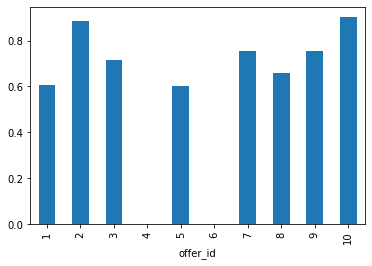

In [68]:
# plot compeleted rate by offer_id
offer_completed_rate.plot.bar()

#### Summary
Offer 2 and offer 10 has the highest completed rate.

Offer 2 is discount 7-3.

Offer 10 is discount 10-2.

### 2. Which income or gender completed offer most?

In [69]:
# count completed offer group by income
offer_completed_by_income=offer_received.groupby('income')['completed_count'].sum()

<AxesSubplot:xlabel='income'>

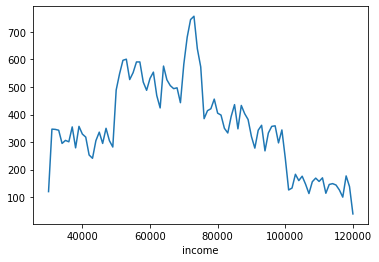

In [70]:
# plot chart
offer_completed_by_income.plot()

In [71]:
# count completed offer group by gender
offer_completed_by_gender=offer_received.groupby('gender')['completed_count'].sum()

<AxesSubplot:xlabel='gender'>

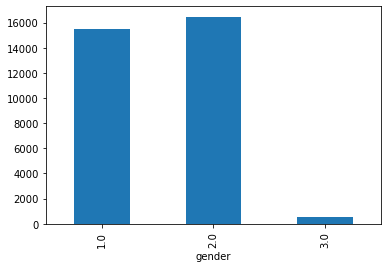

In [72]:
# plot bar chart 
offer_completed_by_gender.plot.bar()

#### Summay
Income in range(60000,80000) has higher completed transactions.

Male has little higher completed transactions than Female.

### 3. What's the memberdays distribution

<AxesSubplot:>

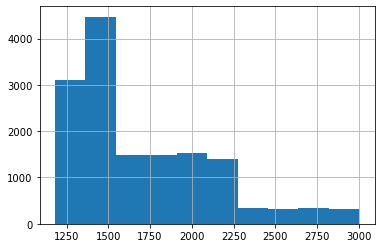

In [73]:
profile_new['memberdays'].hist()

#### Summary
Most of users became Starbucks within 5 years.

# Data Modeling

In [74]:
offer_received.columns

Index(['customer_id', 'event', 'offer_id', 'viewed_count', 'completed_count',
       'completed', 'reward', 'difficulty', 'duration_hours', 'web', 'mobile',
       'email', 'social', 'bogo', 'discount', 'informational', 'gender', 'age',
       'income', 'memberdays'],
      dtype='object')

In [75]:
# choose feature columns and predict value
X=offer_received[['reward', 'difficulty', 'duration_hours', 'web', 'social',
       'email', 'mobile', 'bogo', 'discount', 'informational', 'gender', 'age',
       'income', 'memberdays']]
y=offer_received['completed']

In [76]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

### 1. Decision Tree

In [77]:
dt_clf = DecisionTreeClassifier()

dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
print('\n',classification_report(y_test,y_pred))


               precision    recall  f1-score   support

         0.0       0.73      0.73      0.73      8186
         1.0       0.74      0.73      0.73      8381

    accuracy                           0.73     16567
   macro avg       0.73      0.73      0.73     16567
weighted avg       0.73      0.73      0.73     16567



### 2. Support Vector Machine

In [78]:
svm = SVC(gamma = 'auto')

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('\n',classification_report(y_test,y_pred))


               precision    recall  f1-score   support

         0.0       0.68      0.25      0.36      8186
         1.0       0.55      0.89      0.68      8381

    accuracy                           0.57     16567
   macro avg       0.61      0.57      0.52     16567
weighted avg       0.61      0.57      0.52     16567



### 3. Naive Bayes

In [79]:
gnb = GaussianNB() 

gnb.fit(X_train, y_train) 
y_pred = gnb.predict(X_test)
print('\n',classification_report(y_test,y_pred))


               precision    recall  f1-score   support

         0.0       0.91      0.46      0.61      8186
         1.0       0.64      0.95      0.77      8381

    accuracy                           0.71     16567
   macro avg       0.78      0.71      0.69     16567
weighted avg       0.78      0.71      0.69     16567



### 4. Random Forest

In [80]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('\n',classification_report(y_test,y_pred))


               precision    recall  f1-score   support

         0.0       0.78      0.73      0.75      8186
         1.0       0.75      0.80      0.77      8381

    accuracy                           0.77     16567
   macro avg       0.77      0.76      0.76     16567
weighted avg       0.77      0.77      0.76     16567



### 5. K-Nearest Neighbors

In [81]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('\n',classification_report(y_test,y_pred))


               precision    recall  f1-score   support

         0.0       0.73      0.70      0.71      8186
         1.0       0.72      0.74      0.73      8381

    accuracy                           0.72     16567
   macro avg       0.72      0.72      0.72     16567
weighted avg       0.72      0.72      0.72     16567



### 6. LogisticRegression

In [82]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('\n',classification_report(y_test,y_pred))


               precision    recall  f1-score   support

         0.0       0.65      0.52      0.58      8186
         1.0       0.61      0.73      0.66      8381

    accuracy                           0.63     16567
   macro avg       0.63      0.63      0.62     16567
weighted avg       0.63      0.63      0.62     16567



# Conclusion

Random Forest model has best performance among those 6 models, I plan to use it to recommend offer for users.

### How to use the model to predict right offer to a user
For example, we have a new regiserted user, how to use this model to auto recommend offer?
User info as below: ['age':35,'gender':F,'income':50000,'memberdays':1]

In [83]:
gender_num_map

{'gender': {'F': 1, 'M': 2, 'O': 3}}

In [84]:
def user_offer_recommendation(gender,age,income,memberdays):
    '''    
    INPUT:
    gender - (int) {'F': 1, 'M': 2, 'O': 3}
    age - (int)
    income - (int)
    memberdays - (int)
    
    OUTPUT:
    user_offer_recs -  (pandas df) dataframe of the recommendation offers for the user
    '''
    # create direct for user info
    data={'gender':gender, 'age':age,'income':income, 'memberdays':memberdays}
    
    # create copy df from portfolio_new
    user_offer_info=portfolio_new.copy()
    
    # Assign the user info to the user_offer_info df
    for k,v in data.items():
        user_offer_info.loc[:,k]=v
        
    # create X metric for prediction   
    X=user_offer_info.drop(['offer_id'],axis=1)
    
    # Predict the value and assign the value to new completed column
    user_offer_info['pred_completed']=rf.predict(X)
    prob=rf.predict_proba(X)
    user_offer_info['prob_completed']=prob[:,1]
    user_offer_recs=user_offer_info[['offer_id','pred_completed','prob_completed']].sort_values(by='prob_completed',ascending=False)
    
    return user_offer_recs

In [85]:
# User the function to predict the user offer which are most likely to complete
example_recs=user_offer_recommendation(gender=1,age=35,income=50000,memberdays=1)

In [86]:
example_recs

,offer_id,pred_completed,prob_completed
6,10,1.0,0.65
3,7,0.0,0.50
9,3,0.0,0.49
8,9,0.0,0.47
4,1,0.0,0.46
5,2,0.0,0.44
0,8,0.0,0.38
1,5,0.0,0.23
2,4,0.0,0.00
7,6,0.0,0.00


### Make recommendation
Base on above result, we will recommend offer_id=10 for the user, which is discount 10-2.